## Import your stuff

In [1]:
import numpy as np
import scipy.integrate as integrate
import pydelfi.ndes as ndes
from pydelfi import delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
import h5py
from astropy.cosmology import Planck15, z_at_value, FlatwCDM
import astropy.units as u
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [2]:
def pisn_parse(z_min=None, z_max=None, qual_cut=False, \
        pisn_path='/Users/hyraland/Projects/GW/Cosmology/PISNLineCosmography/'):

    filename = 'm90.txt'
    datar = np.loadtxt(pisn_path + filename)

    # keys: etaobs,m1s,m2s,mcobs,posterior,rhoobs,sigma_eta,sigma_mc,sigma_rho,sigma_t,thetaobs,thetas
    dl = datar[0]#[1:]
    m90 = datar[1]#[1:]
    m90std = datar[2]#[1:]
    dlstd = datar[3]#[1:]

    # take m1 as data for now
    data = {'dl':dl, 'm90':m90,'m90std':m90std,'dlstd':dlstd} 
    n_sn = len(data['dl'])

    cmats = {'m90': np.zeros((n_sn, n_sn))}
    for cmat in cmats:
        d = data['m90std']
        for i in range(n_sn):
            cmats[cmat][i, i] = d[i]**2

    return data, cmats

In [3]:
class PISN_Model():

    def __init__(self, pisn_data_path = '/Users/hyraland/Projects/GW/Cosmology/PISNLineCosmography/'):

        # Import data
        pisn_data, pisn_cmats = pisn_parse(z_min=None, z_max=None, qual_cut=False,
                                           pisn_path='/Users/hyraland/Projects/GW/Cosmology/PISNLineCosmography/')
        
        self.data = np.array([ 61.22040306,  72.20696141, 81.69839776,  89.69248822,  99.04126598, 104.80271241, 113.8196791,  118.69071364, 117.39444138])# pisn_data['m90'] # pisn_data['dl_z'] 
        delta_m_cut = 10
        self.auxiliary_data = np.column_stack([pisn_data['dl']])

        # h0, omegam, w
        self.npar = 4
        self.theta_fiducial = np.array([Planck15.H0.value, Planck15.Om0, -1.0, 52.0])

        # Covariance matrix
        self.C = pisn_cmats['m90']
        self.Cinv = np.linalg.inv(self.C)
        self.L = np.linalg.cholesky(self.C)

        # Derivative of the covariance matrix
        self.n_sn = len(self.C)
        #self.dCdt = np.zeros((self.npar, self.n_sn, self.n_sn))

        # N data points
        self.ndata = len(pisn_data['m90'])

        # Compute the mean
        self.m90 = self.dlofz(self.theta_fiducial)

    # luminosity distance
    def dlofz(self, theta):
        
        # Cosmological parameters
        h0 = theta[0]
        omegam = theta[1]
        om = theta[2]
        m90_0 = theta[3]
        
        cosm = FlatwCDM(h0, omegam, om)
        m90 = np.linspace(0,0,len(self.auxiliary_data[:,0]))
        for i in range(len(self.auxiliary_data[:,0])):
            z = z_at_value(cosm.luminosity_distance, self.auxiliary_data[i,0]*u.Gpc)        
        # Pull out the relevant things from the data
            m90[i] = m90_0*(z + 1)
                
        return m90

    # Generate realisation of \mu
    def simulation(self, theta, seed):
        
        # Set the seed
        np.random.seed(seed)

        # Signal
        m90s = self.dlofz(theta)
        
        # Noise
        noise = np.dot(self.L, np.random.normal(0, 1, len(self.L)))
        
        # Return signal + noise
        return m90s + noise

    # Generate derivative of \mu w.r.t cosmological parameters
    def dmudt(self, theta_fiducial, h):
        
        # dmdt
        dmdt = np.zeros((self.npar, self.ndata))
        
        # Fiducial data
        d_fiducial = self.dlofz(theta_fiducial)
        
        # Loop over parameters
        for i in range(0, 4):
            
            # Step theta
            theta = np.copy(self.theta_fiducial)
            theta[i] += h[i]
            
            # Shifted data with same seed
            d_dash = self.dlofz(theta)
            
            # One step derivative
            dmdt[i,:] = (d_dash - d_fiducial)/h[i]
        
        return dmdt



In [4]:
PISNSimulator = PISN_Model()

def simulator(theta, seed, simulator_args, batch):
    
    return PISNSimulator.simulation(theta, seed)

simulator_args = None

## Set up the prior

In [5]:
theta_fiducial = np.array([Planck15.H0.value, Planck15.Om0, -1.0, 52.0])

prior_low = np.array([35.0, 0.0, -2.0, 30.0])
prior_high = np.array([140.0, 1.0, 0.0, 85.0])

# Use these priors if you just want to measure w:
#prior_C = np.diag([(0.01*theta_fiducial[0])**2, (0.01*theta_fiducial[1])**2, 0.5**2, 10.0**2])

# Use these priors if you don't want to measure w, but want to just constrain cosmology:
#prior_C = np.diag([15**2, 0.15**2, 0.5**2, 10.0**2])

Om = Planck15.Om0
H0 = Planck15.H0.value
h0 = Planck15.H0.value/100

# Use this to include H0 Om covariance
Covhomh2 = np.diag([(0.01*H0)**2, (0.01*Om*h0**2)**2])
J = np.array([[1.0, 0.0], [2.0*Om*h0/100.0, h0**2]])# d(H0, Omh2)/d(H0, Om)
Jinv = np.linalg.inv(J)
Covhom = np.dot(Jinv.T, np.dot(Covhomh2, Jinv))

# Parameter order is H0, Om, w, m90
prior_C = np.diag([0.7**2, 0.**2, 0.5**2, 10.0**2])
prior_C[0:2, 0:2] = Covhom

prior = priors.TruncatedGaussian(theta_fiducial, prior_C, prior_low, prior_high)

## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

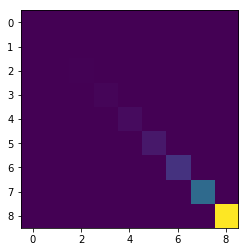

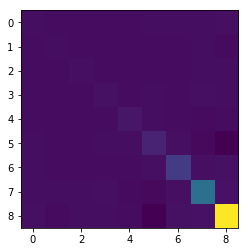


[[ 0.13635888  0.24905883  0.35664798  0.45880434  0.55771361  0.65264132
   0.74458237  0.83507532  0.9251772 ]
 [ 1.34895909  4.56848621  9.1679682  14.58087281 20.53144213 26.72529368
  33.06071543 39.54390917 46.1881181 ]
 [ 0.77595945  2.25636447  3.96432581  5.63596797  7.20877305  8.64464754
   9.95955146 11.18333621 12.33787942]
 [ 1.19822586  1.38133915  1.56110824  1.73167376  1.89515865  2.05015946
   2.19855274  2.34308294  2.48566004]]
[[ 0.13635888  0.24905883  0.35664798  0.45880434  0.55771361  0.65264132
   0.74458237  0.83507532  0.9251772 ]
 [ 1.34895909  4.56848621  9.1679682  14.58087281 20.53144213 26.72529368
  33.06071543 39.54390917 46.1881181 ]
 [ 0.77595945  2.25636447  3.96432581  5.63596797  7.20877305  8.64464754
   9.95955146 11.18333621 12.33787942]
 [ 1.19822586  1.38133915  1.56110824  1.73167376  1.89515865  2.05015946
   2.19855274  2.34308294  2.48566004]]


In [6]:
mu = PISNSimulator.dlofz(theta_fiducial)
Cinv = PISNSimulator.Cinv

h = np.array(abs(theta_fiducial))*0.01
dmudt = PISNSimulator.dmudt(theta_fiducial, h)

Compressor = score.Gaussian(len(PISNSimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt, prior_mean=theta_fiducial, prior_covariance=prior_C)
Compressor.compute_fisher()
Finv = Compressor.Finv
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

Compressor.compute_mean_covariance(simulator = simulator, nsims = 200)
Compressor.compute_fisher()

plt.imshow(PISNSimulator.C)
plt.show()
plt.imshow(Compressor.C)
plt.show()

np.random.seed()
Compressor.compute_derivatives(simulator = simulator, nsims = 200, h=h)
print(dmudt)
print(Compressor.dmudt)


<ErrorbarContainer object of 3 artists>

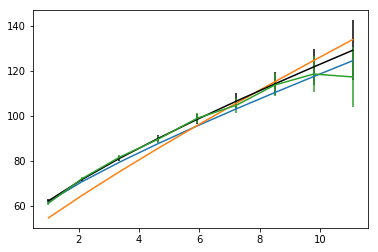

In [7]:
plt.errorbar(PISNSimulator.auxiliary_data[:,0], PISNSimulator.dlofz(theta_fiducial), np.diag(PISNSimulator.L), color='k')

plt.plot(PISNSimulator.auxiliary_data[:,0], PISNSimulator.dlofz(theta_fiducial+np.array([0.0, 0, -0.5, 0])))
plt.plot(PISNSimulator.auxiliary_data[:,0], PISNSimulator.dlofz(np.array([67.8, 0.308, 0.0, 45])))
plt.errorbar(PISNSimulator.auxiliary_data[:,0], PISNSimulator.data, yerr = (np.diag(PISNSimulator.L)))

In [8]:
np.sqrt(np.diag(Finv))

array([0.67576254, 0.00307445, 0.23298354, 0.55393707])

800/|/100%|| 800/800 [01:18<00:00, 14.63it/s]

In [9]:
evals, evecs = np.linalg.eigh(Compressor.Finv)

In [10]:
np.sqrt(evals), evecs

(array([0.00306737, 0.10302446, 0.56052206, 0.68519484]),
 array([[-1.63904537e-04, -8.21152565e-02,  2.50710183e-01,
         -9.64573202e-01],
        [-9.99997972e-01,  2.01361620e-03,  3.66578486e-05,
          8.03058748e-06],
        [-1.88628898e-03, -9.30016120e-01, -3.67154176e-01,
         -1.62563808e-02],
        [-6.86372838e-04, -3.58222064e-01,  8.95735571e-01,
          2.63314011e-01]]))

[ 62.12428727  71.83101999  80.32579052  89.37997524  96.12854692
 107.56179065 103.17097618 113.59652868 131.90471652]


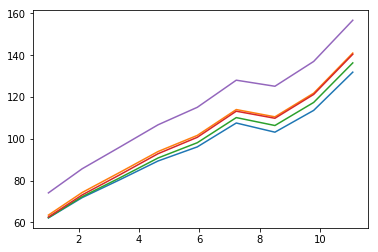

In [13]:
s = np.random.randint(1<<32)
print(simulator(theta_fiducial, s, None, 1))
plt.plot(PISNSimulator.auxiliary_data, simulator(theta_fiducial, s, None, 1))
plt.plot(PISNSimulator.auxiliary_data,simulator(theta_fiducial + np.array([10.0,0,0,0]), s, None, 1))
plt.plot(PISNSimulator.auxiliary_data,simulator(theta_fiducial + np.array([0.0,0.1,0,0]), s, None, 1))
plt.plot(PISNSimulator.auxiliary_data,simulator(theta_fiducial + np.array([0.0,0,+0.5,0]), s, None, 1))
plt.plot(PISNSimulator.auxiliary_data,simulator(theta_fiducial + np.array([0.0,0,0,10.]), s, None, 1))

# s = np.random.randint(1<<32)
# plt.plot(PISNSimulator.auxiliary_data, simulator(theta_fiducial, s, None, 1))
# s = np.random.randint(1<<32)
# plt.plot(PISNSimulator.auxiliary_data, simulator(theta_fiducial, s, None, 1))

## Load in the compressed data

In [14]:
compressed_data = compressor(PISNSimulator.data, compressor_args)

## Define ensemble of NDEs

In [15]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=4, n_data=4, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=4, n_data=4, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=4, n_data=4, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=4, n_data=4, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=4, n_data=4, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=4, n_data=4, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Create DELFI object

In [16]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [prior_low, prior_high],
                            param_names = ['h_0', 'Omega_0', 'omega','m90'], 
                            results_dir = "simulators/pisn/results/",
                            input_normalization="fisher")

## Fisher pre-training to initialize the NDEs


Sampling approximate posterior...
Done.


/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


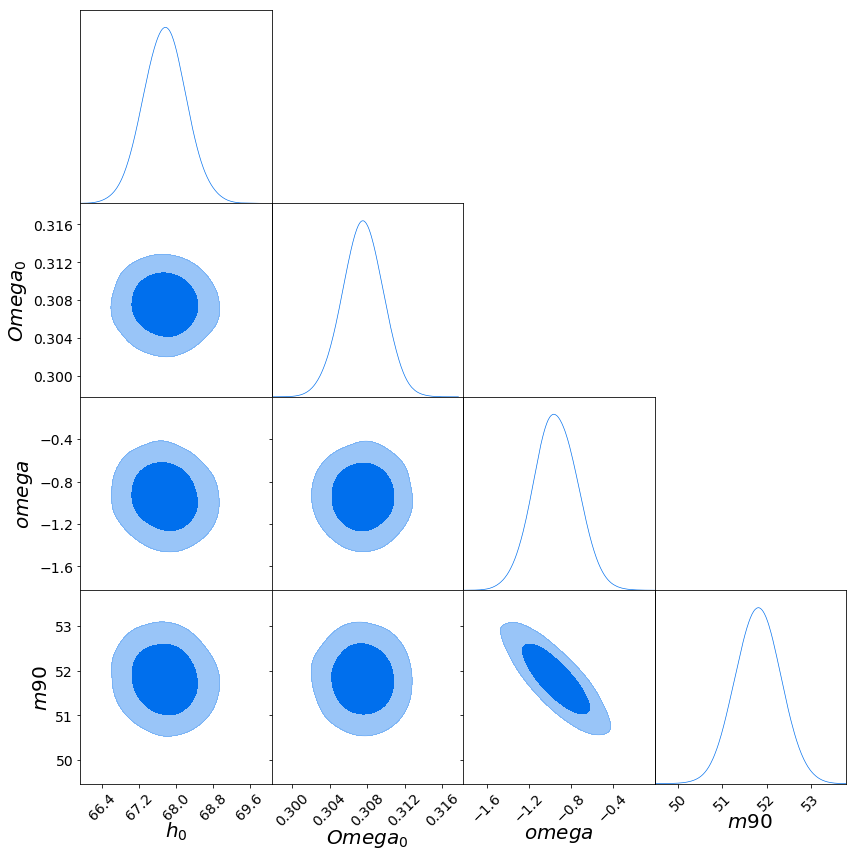

In [17]:
DelfiEnsemble.fisher_pretraining()

## Sequential Neural Likelihood


Population 1/10
Sampling proposal density...
Done.


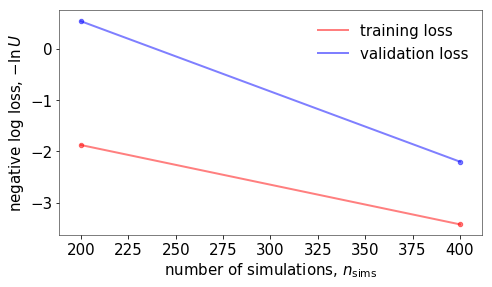

Population 2/10
Sampling proposal density...
83/|/ 28%|| 83/300 [00:35<00:24,  8.80it/s, train loss=-4.13, val loss=-0.99, refresh=1]Done.


200it [00:22, 16.98it/s]


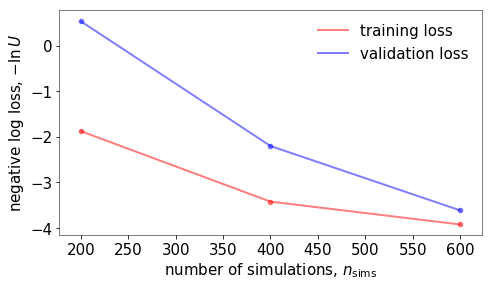

Population 3/10
Sampling proposal density...
67/|/ 22%|| 67/300 [00:27<00:20, 11.23it/s, train loss=-4.72, val loss=-4.14, refresh=1]Done.


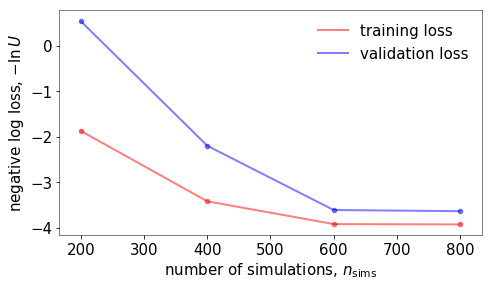

Population 4/10
Sampling proposal density...
33/|/ 11%|| 33/300 [00:29<00:57,  4.63it/s, train loss=-4.47, val loss=-4.05, refresh=1]Done.


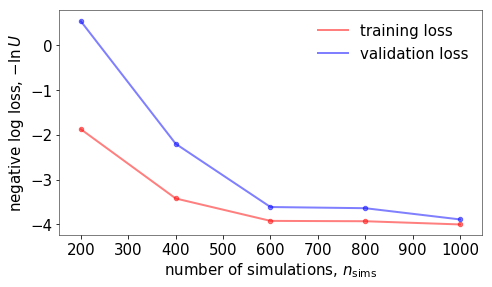

Population 5/10
Sampling proposal density...
36/|/ 12%|| 36/300 [00:26<00:45,  5.77it/s, train loss=-4.56, val loss=-4.3, refresh=1]Done.


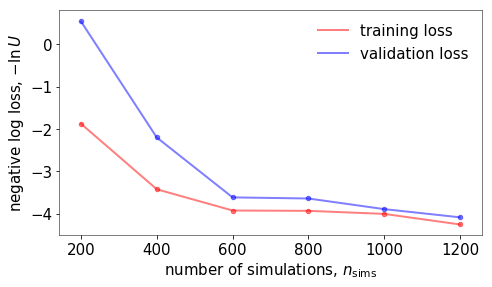

Population 6/10
Sampling proposal density...
39/|/ 13%|| 39/300 [00:33<00:31,  8.31it/s, train loss=-4.68, val loss=-4.33, refresh=1]Done.


98/|/ 33%|| 98/300 [00:33<00:23,  8.61it/s, train loss=-4.17, val loss=-4.16, refresh=1]


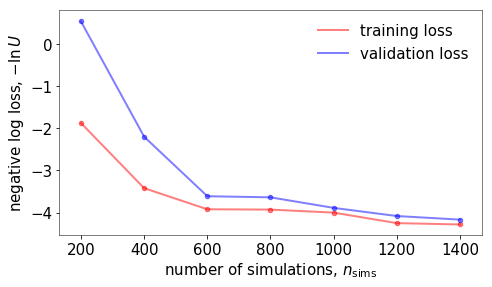

Population 7/10
Sampling proposal density...
22/|/  7%|| 22/300 [00:22<01:19,  3.50it/s, train loss=-4.67, val loss=-4.44, refresh=1]Done.


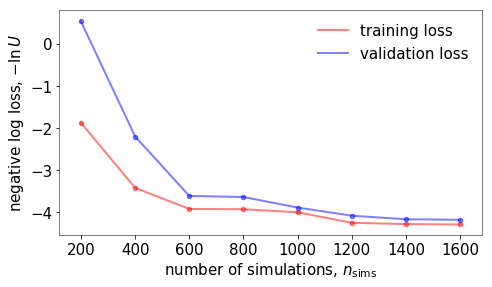

Population 8/10
Sampling proposal density...
23/|/  8%|| 23/300 [00:23<01:06,  4.16it/s, train loss=-4.58, val loss=-4.63, refresh=1]Done.


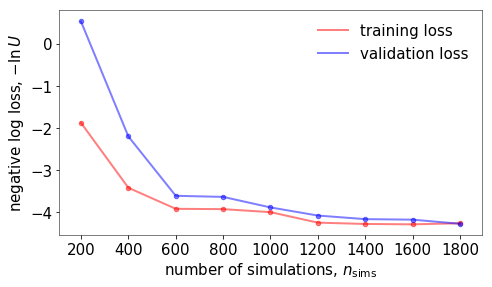

Population 9/10
Sampling proposal density...
22/|/  7%|| 22/300 [00:21<01:58,  2.34it/s, train loss=-4.52, val loss=-4.51, refresh=1]Done.


106/|/ 35%|| 106/300 [00:41<00:36,  5.34it/s, train loss=-4.37, val loss=-4.34, refresh=1]


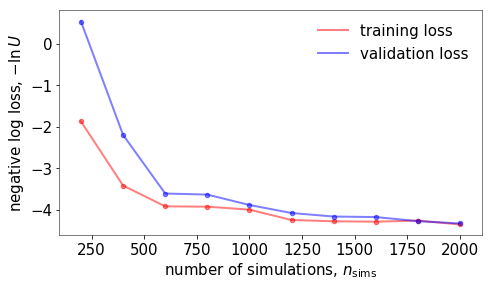

Population 10/10
Sampling proposal density...
40/|/ 13%|| 40/300 [00:26<01:05,  4.00it/s, train loss=-4.61, val loss=-4.5, refresh=1]Done.


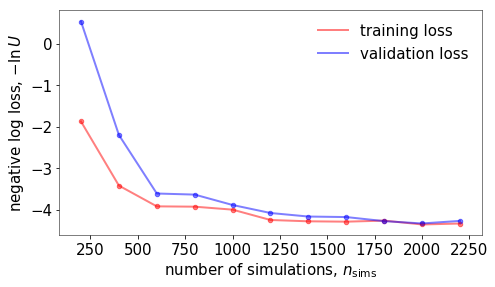

22/|/  7%|| 22/300 [00:24<01:47,  2.58it/s, train loss=-4.55, val loss=-4.52, refresh=1]

In [18]:
n_initial = 200
n_batch = 200
n_populations = 10

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20,
                       save_intermediate_posteriors=False)

## Sample the learned posterior

In [18]:
posterior_samples = DelfiEnsemble.emcee_sample()

28/|/  9%|| 28/300 [00:24<01:39,  2.75it/s, train loss=-4.6, val loss=-4.34, refresh=1]

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


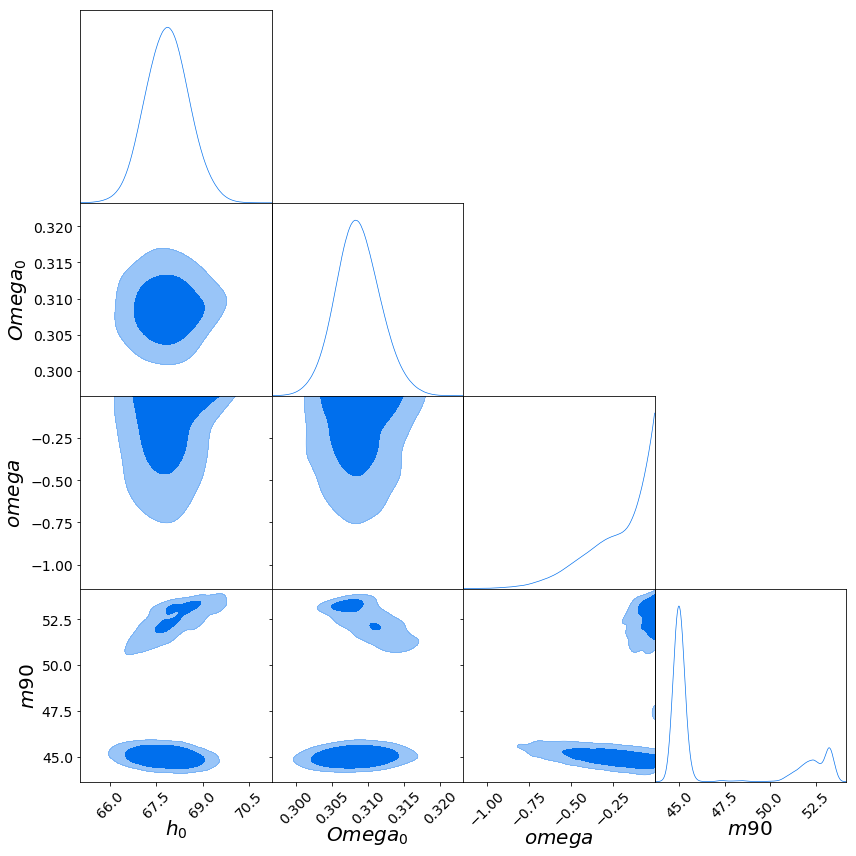

In [19]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples])